In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# Classifying movie reviews: a binary classification example

This notebook contains the code samples found in Chapter 3, Section 5 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----
二分类问题可能是应用最广泛的机器学习问题。在这个例子中，你将学习根据电影评论的文字内容将其划分为正面或负面。

## The IMDB dataset


本节使用 IMDB 数据集，它包含来自互联网电影数据库（IMDB）的 50 000 条严重两极分化的评论。数据集被分为用于训练的 25 000 条评论与用于测试的 25 000 条评论，训练集和测试集都包含 50% 的正面评论和 50% 的负面评论。

为什么要将训练集和测试集分开？因为你不应该将训练机器学习模型的同一批数据再用于测试模型！模型在训练数据上的表现很好，并不意味着它在前所未见的数据上也会表现得很好，而且你真正关心的是模型在新数据上的性能（因为你已经知道了训练数据对应的标签，显然不再需要模型来进行预测）。例如，你的模型最终可能只是记住了训练样本和目标值之间的映射关系，但这对在前所未见的数据上进行预测毫无用处。下一章将会更详细地讨论这一点。

与 MNIST 数据集一样，IMDB 数据集也内置于 Keras 库。它已经过预处理：评论（单词序列） 已经被转换为整数序列，其中每个整数代表字典中的某个单词。 下列代码将会加载 IMDB 数据集（第一次运行时会下载大约 80MB 的数据，可以不翻墙，反复试几次）。

In [2]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 1s 0us/step


参数 num_words=10000 的意思是仅保留训练数据中前 10 000 个最常出现的单词。低频单词将被舍弃。这样得到的向量数据不会太大，便于处理。

train_data 和 test_data 这两个变量都是评论组成的列表，每条评论又是单词索引组成 的列表（表示一系列单词）。train_labels 和 test_labels 都是 0 和 1 组成的列表，其中 0 代表负面（negative），1 代表正面（positive）。

In [0]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [3]:
train_labels[0]

1

由于限定为前 10 000 个最常见的单词，单词索引都不会超过 10 000。

In [0]:
max([max(sequence) for sequence in train_data])

9999

如果好奇的话，你可以用下列代码将索引解码为单词。 下载太慢

In [4]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
#将评论解码。注意，索引减去了 3，
# 因为 0、1、2 是为“padding”（填充）、“start of sequence”（序列开始）、“unknown”（未知词）分别保留的索引
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

1646592/1641221 [==============================] - 0s 0us/step


In [0]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

## Preparing the data


你不能将整数序列直接输入神经网络。你需要将列表转换为张量。转换方法有以下两种。

* 填充列表，使其具有相同的长度，再将列表转换成形状为 (samples, word_indices) 的整数张量，然后网络第一层使用能处理这种整数张量的层（即 Embedding 层，本书后面会详细介绍）。

* 对列表进行 one-hot 编码，将其转换为 0 和 1 组成的向量。举个例子，序列 [3, 5] 将会 被转换为 10 000 维向量，只有索引为 3 和 5 的元素是 1，其余元素都是 0。然后网络第一层可以用 Dense 层，它能够处理浮点数向量数据。

下面我们采用后一种方法将数据向量化。为了加深理解，你可以手动实现这一方法，如下所示。

In [0]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results


In [6]:
train_data.shape

(25000,)

In [7]:
test_data.shape

(25000,)

In [0]:
# Our vectorized training data 直接25000个数据太多了，容易崩掉
x_train = vectorize_sequences(train_data)

In [0]:
# Our vectorized test data
x_test = vectorize_sequences(test_data)

Here's what our samples look like now:

In [10]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [11]:
x_train[0].shape

(10000,)

We should also vectorize our labels, which is straightforward:

In [0]:
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

Now our data is ready to be fed into a neural network.

## Building our network

输入数据是向量，而标签是标量（1 和 0），这是你会遇到的最简单的情况。有一类网络在这种问题上表现很好， 就是带有 relu 激 活的全连接层（Dense）的简单堆叠，比如Dense(16, activation='relu')。

传入 Dense 层的参数（16）是该层隐藏单元的个数。一个隐藏单元（hidden unit）是该层 表示空间的一个维度。我们在第 2 章讲过，每个带有 relu 激活的 Dense 层都实现了下列张量运算：

output = relu(dot(W, input) + b)

16 个隐藏单元对应的权重矩阵 W 的形状为 (input_dimension, 16)，与 W 做点积相当于将输入数据投影到 16 维表示空间中（然后再加上偏置向量 b 并应用 relu 运算）。你可以将表示空间的维度直观地理解为“网络学习内部表示时所拥有的自由度”。隐藏单元越多（即更高维的表示空间），网络越能够学到更加复杂的表示，但网络的计算代价也变得更大，而且可能会导致学到不好的模式（这种模式会提高训练数据上的性能，但不会提高测试数据上的性能）。对于这种 Dense 层的堆叠，你需要确定以下两个关键架构：

* 网络有多少层；

* 每层有多少个隐藏单元。

下一章中的原则将会指导你对上述问题做出选择。现在你只需要相信我选择的下列架构：

* 两个中间层，每层都有 16 个隐藏单元；

* 第三层输出一个标量，预测当前评论的情感。

中间层使用 relu 作为激活函数，最后一层使用 sigmoid 激活以输出一个 0~1 范围内的概率值（表示样本的目标值等于 1 的可能性，即评论为正面的可能性）。relu（rectified linear unit，整流线性单元）函数将所有负值归零，而 sigmoid 函数则将任意值“压缩”到 [0,1] 区间内，其输出值可以看作概率值。

Here's what our network looks like:

![3-layer network](https://s3.amazonaws.com/book.keras.io/img/ch3/3_layer_network.png)

代码清单是其 Keras 实现，与前面见过的 MNIST 例子类似。

In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


最后，你需要选择损失函数和优化器。由于你面对的是一个二分类问题，网络输出是一个概率值（网络最后一层使用 sigmoid 激活函数，仅包含一个单元），那么最好使用 binary_crossentropy （二元交叉熵）损失。这并不是唯一可行的选择，比如你还可以使用 mean_squared_error（均方误差）。但对于输出概率值的模型，交叉熵（crossentropy）往往是最好的选择。交叉熵是来自于信息论领域的概念，用于衡量概率分布之间的距离，在这个例子中就是真实分布与预测值之间的距离。

下面的步骤是用 rmsprop 优化器和 binary_crossentropy 损失函数来配置模型。注意，我们还在训练过程中监控精度。

In [0]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

上述代码将优化器、损失函数和指标作为字符串传入，这是因为 rmsprop、binary_ crossentropy 和 accuracy 都是 Keras 内置的一部分。有时你可能希望配置自定义优化器的 参数，或者传入自定义的损失函数或指标函数。前者可通过向 optimizer 参数传入一个优化器类实例来实现，如代码所示：

In [0]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

后者可通过向 loss 和 metrics 参数传入函数对象来实现， 如代码所示。

In [0]:
from keras import losses
from keras import metrics

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

## Validating our approach

In order to monitor during training the accuracy of the model on data that it has never seen before, we will create a "validation set" by 
setting apart 10,000 samples from the original training data:

In [0]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

We will now train our model for 20 epochs (20 iterations over all samples in the `x_train` and `y_train` tensors), in mini-batches of 512 
samples. At this same time we will monitor loss and accuracy on the 10,000 samples that we set apart. This is done by passing the 
validation data as the `validation_data` argument:

In [18]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=50,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/50
15000/15000 [==============================] - 3s 208us/step - loss: 0.5084 - binary_accuracy: 0.7813 - val_loss: 0.3797 - val_binary_accuracy: 0.8684
Epoch 2/50
15000/15000 [==============================] - 2s 104us/step - loss: 0.3004 - binary_accuracy: 0.9047 - val_loss: 0.3004 - val_binary_accuracy: 0.8897
Epoch 3/50
15000/15000 [==============================] - 2s 104us/step - loss: 0.2179 - binary_accuracy: 0.9285 - val_loss: 0.3085 - val_binary_accuracy: 0.8711
Epoch 4/50
15000/15000 [==============================] - 2s 104us/step - loss: 0.1750 - binary_accuracy: 0.9437 - val_loss: 0.2840 - val_binary_accuracy: 0.8832
Epoch 5/50
15000/15000 [==============================] - 2s 105us/step - loss: 0.1427 - binary_accuracy: 0.9543 - val_loss: 0.2841 - val_binary_accuracy: 0.8872
Epoch 6/50
15000/15000 [==============================] - 2s 106us/step - loss: 0.1150 - binary_accuracy: 0.9650 - val_loss: 0.3166 - val_bi

在 CPU 上运行，每轮的时间不到 2 秒，训练过程将在 20 秒内结束。每轮结束时会有短暂的停顿，因为模型要计算在验证集的 10 000 个样本上的损失和精度。 

注意，调用 model.fit() 返回了一个 History 对象。这个对象有一个成员 history，它是一个字典，包含训练过程中的所有数据。我们来看一下。

In [19]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])

It contains 4 entries: one per metric that was being monitored, during training and during validation. Let's use Matplotlib to plot the 
training and validation loss side by side, as well as the training and validation accuracy:

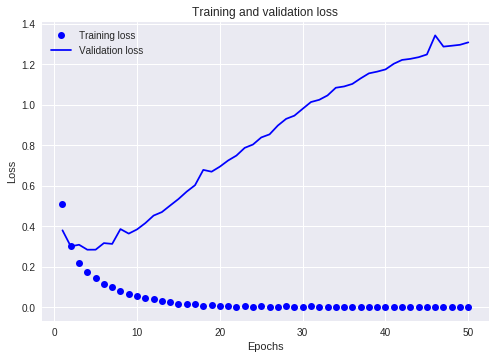

In [20]:
import matplotlib.pyplot as plt

# acc = history.history['acc']
# val_acc = history.history['val_acc']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

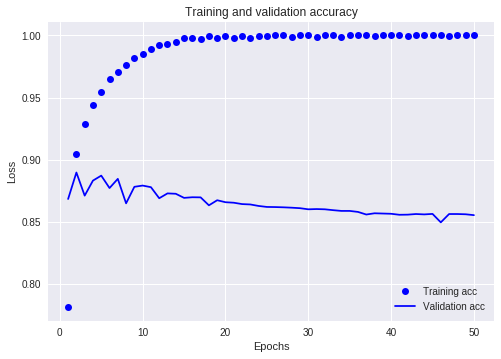

In [21]:
plt.clf()   # clear figure（清空图像）
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


点是训练损失和准确率，而实线是验证损失和准确性。 请注意，由于网络的随机初始化不同，您自己的结果可能略有不同。

如你所见，训练损失每轮都在降低，训练精度每轮都在提升。这就是梯度下降优化的预期 结果——你想要最小化的量随着每次迭代越来越小。但验证损失和验证精度并非如此：它们似 乎在第四轮达到最佳值。这就是我们之前警告过的一种情况：模型在训练数据上的表现越来越好， 但在前所未见的数据上不一定表现得越来越好。准确地说，你看到的是过拟合（overfit）：在第二轮之后，你对训练数据过度优化，最终学到的表示仅针对于训练数据，无法泛化到训练集之外的数据。

在这种情况下，为了防止过拟合，你可以在 3 轮之后停止训练。通常来说，你可以使用许 多方法来降低过拟合，我们将在第 4 章中详细介绍。

我们从头开始训练一个新的网络，训练 4 轮，然后在测试数据上评估模型。

In [0]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
25000/25000 [==============================] - 2s 73us/step - loss: 0.4749 - acc: 0.8217
Epoch 2/4
25000/25000 [==============================] - 2s 71us/step - loss: 0.2666 - acc: 0.9096
Epoch 3/4
25000/25000 [==============================] - 2s 70us/step - loss: 0.1987 - acc: 0.9292
Epoch 4/4
25000/25000 [==============================] - 3s 105us/step


In [0]:
results

[0.32385538100242617, 0.87308]

Our fairly naive approach achieves an accuracy of 88%. With state-of-the-art approaches, one should be able to get close to 95%.

## Using a trained network to generate predictions on new data

训练好网络之后，你希望将其用于实践。你可以用 predict 方法来得到评论为正面的可能性大小。

In [0]:
model.predict(x_test)

array([[0.13560073],
       [0.9997118 ],
       [0.27816316],
       ...,
       [0.0713997 ],
       [0.04283792],
       [0.47383907]], dtype=float32)

如你所见，网络对某些样本的结果非常确信（大于等于 0.99，或小于等于 0.01），但对其他结果却不那么确信（0.6 或 0.4）。 


## Further experiments


通过以下实验，你可以确信前面选择的网络架构是非常合理的，虽然仍有改进的空间。

* 前面使用了两个隐藏层。你可以尝试使用一个或三个隐藏层，然后观察对验证精度和测试精度的影响。

* 尝试使用更多或更少的隐藏单元，比如 32 个、64 个等。

* 尝试使用 mse 损失函数代替 binary_crossentropy。

* 尝试使用 tanh 激活（这种激活在神经网络早期非常流行）代替 relu。

这些实验将有助于说服您，我们所做的架构选择都是相当合理的，尽管它们仍然可以改进！

## Conclusions


下面是你应该从这个例子中学到的要点。

* 通常需要对原始数据进行大量预处理，以便将其转换为张量输入到神经网络中。单词序列可以编码为二进制向量，但也有其他编码方式。

* 带有 relu 激活的 Dense 层堆叠，可以解决很多种问题（包括情感分类），你可能会经常用到这种模型。

* 对于二分类问题（两个输出类别），网络的最后一层应该是只有一个单元并使用 sigmoid激活的 Dense 层，网络输出应该是 0~1 范围内的标量，表示概率值。

* 对于二分类问题的 sigmoid 标量输出，你应该使用 binary_crossentropy 损失函数。

* 无论你的问题是什么，rmsprop 优化器通常都是足够好的选择。这一点你无须担心。

随着神经网络在训练数据上的表现越来越好，模型最终会过拟合，并在前所未见的数据上得到越来越差的结果。一定要一直监控模型在训练集之外的数据上的性能。
